<a href="https://colab.research.google.com/github/EronDS/Neural-Networks/blob/main/Autoencoder/Variational_Autoencoder/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install utils

In [15]:
from keras.models import Sequential,Model
from keras.layers import Input,Dense,Flatten,Conv2D,Conv2DTranspose,MaxPool2D, Activation, LeakyReLU, Reshape
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical,plot_model
import numpy as np 
import tensorflow.keras.backend as K
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [16]:
(x_train, y_train) , (x_test , y_test) = mnist.load_data()
(real_imgs_train, _) , (real_imgs_test , _) = mnist.load_data()


In [17]:
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255 

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

NumCategories = 10 

In [18]:
x_train = np.reshape(x_train, [-1 , 28,28,1])
x_test = np.reshape(x_test, [-1 , 28,28,1])

In [19]:
x_train.shape

(60000, 28, 28, 1)

In [20]:
input_shape = [28,28,1]

inputs = Input(shape = input_shape, name = 'encoder_inputs')
filters = [32,64,64]
z = 0
x = inputs
for filter in filters:
  if filter == 64:
    x = Conv2D(filters = filter, kernel_size= 3,
                    strides =2, padding ='same' , 
                    activation = 'relu')(x)
    x = LeakyReLU()(x)
  if filter == 32:
    x = Conv2D(filters = filter, kernel_size= 3,
          strides = 1,padding = 'same',
          activation = 'relu')(x)
    x = LeakyReLU()(x)

x = Conv2D(filters = filter, kernel_size= 3,
          strides = 1,padding = 'same',
          activation = 'relu')(x)
x = LeakyReLU()(x)


shape = K.int_shape(x)

x = Flatten()(x)

latentv = Dense(2 , name = 'latent_vector' )(x)

encoder = Model(inputs, latentv , name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0   

In [21]:

latent_inputs = Input(shape = (2,) , name = 'decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1] , shape[2] , shape[3]))(x)

x = Conv2DTranspose(filters = 64, kernel_size= 3,
                    strides =1, padding ='same' , 
                    activation = 'relu')(x)
x = LeakyReLU()(x)

for filter in filters[::-1]:
  if filter == 64:
    x = Conv2DTranspose(filters = filter, kernel_size= 3,
                    strides =2, padding ='same' , 
                    activation = 'relu')(x)
    x = LeakyReLU()(x)
  if filter == 32:
    x = Conv2DTranspose(filters = filter, kernel_size= 3,
          strides = 1,padding = 'same',
          activation = 'relu')(x)
    x = LeakyReLU()(x)

Outputs = Conv2DTranspose(filters = 1, kernel_size = 3,
                          activation = 'sigmoid' , padding = 'same')(x)



decoder = Model(latent_inputs , Outputs, name = 'decoder')
decoder.summary()



Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0   

In [22]:
autoencoder = Model(inputs , decoder(encoder(inputs)) , name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 98946     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         138945    
Total params: 237,891
Trainable params: 237,891
Non-trainable params: 0
_________________________________________________________________


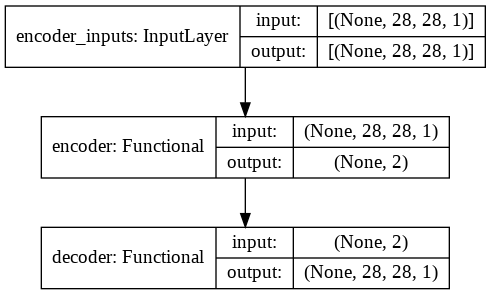

In [23]:
plot_model(autoencoder, show_shapes= True)


In [24]:
optimizer = Adam(learning_rate = 5e-3)


def r_loss(y_true,y_pred):
  return K.mean(K.square(y_true - y_pred) ,axis = [1,2,3])

autoencoder.compile(optimizer = 'adam' , loss = 'mse' , metrics = ['acc'])

In [26]:
LR = ReduceLROnPlateau(monitor = 'loss' , patience = 1 , 
                       verbose = 1)



autoencoder.fit(x_train,x_train,epochs = 1, callbacks = LR)

1875/1875 [==============================] - 423s 226ms/step - loss: 0.0417 - acc: 0.7989


Training Set

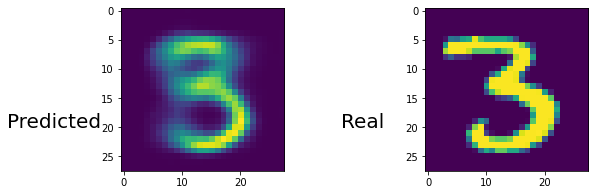

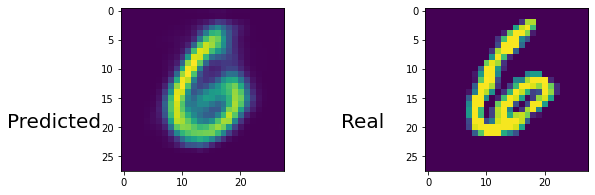

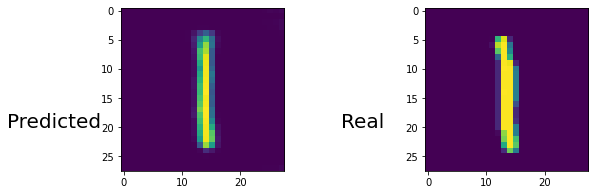

<Figure size 720x216 with 0 Axes>

In [29]:
u = 1
x = 2
for i in range(12,17):
  plt.figure(figsize = (10,3))
  if u >= 7:
    break
  plt.subplot(1,2,1)
  plt.text(-20 , 20 , 'Predicted', fontsize = 20)
  u+= 2
  plt.imshow(np.clip(autoencoder.predict(x_train[i].reshape(1,28 , 28,1)),0.0,1.0).reshape(28, 28,1)[:,:,0])
  x+=2
  plt.subplot(1,2 ,2 )
  plt.text(-15 , 20 , 'Real', fontsize = 20)
  plt.imshow(real_imgs_train[i])

Test Set

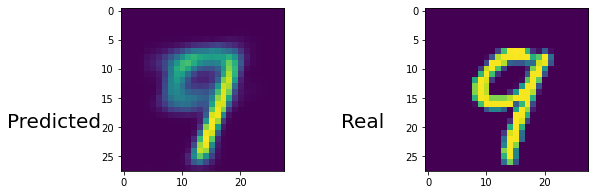

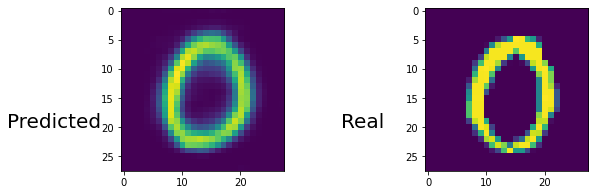

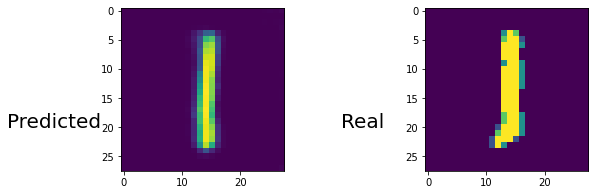

<Figure size 720x216 with 0 Axes>

In [30]:
u = 1
x = 2
for i in range(12,17):
  plt.figure(figsize = (10,3))
  if u >= 7:
    break
  plt.subplot(1,2,1)
  plt.text(-20 , 20 , 'Predicted', fontsize = 20)
  u+= 2
  plt.imshow(np.clip(autoencoder.predict(x_test[i].reshape(1,28 , 28,1)),0.0,1.0).reshape(28, 28,1)[:,:,0])
  x+=2
  plt.subplot(1,2 ,2 )
  plt.text(-15 , 20 , 'Real', fontsize = 20)
  plt.imshow(real_imgs_test[i])

In [34]:
autoencoder.save('VAEMNIST.h5')

In [36]:
from tensorflow.keras.models import load_model
model = load_model('/content/VAEMNIST.h5')

In [37]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 98946     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         138945    
Total params: 237,891
Trainable params: 237,891
Non-trainable params: 0
_________________________________________________________________
